# Modelos no parámetricos

In [1]:
!wget --no-cache -O init.py -q https://raw.githubusercontent.com/jdariasl/Intro_ML_2025/master/init.py
import init; init.init(force_download=False); 

In [1]:

import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm

import scipy
from sklearn import datasets
from sklearn.neighbors import KNeighborsClassifier
from sklearn import preprocessing


import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.pylab import hist, show
import warnings
warnings.filterwarnings("ignore")



from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

CMAP_LIGHT = ListedColormap(['#AAAAFF','#AAFFAA','#FFAAAA',])

Con lo visto hasta ahora podemos establecer que el aprendizaje de máquina se puede ver como el ajuste de un modelo $p(y/{\bf{x}})$ o $p({\bf{x}})$. El primer caso corresponde a un problema de aprendizaje supervisado (regresión o clasifiación) y en el segundo caso a uno no supervisado. Por consiguiente, los problemas de aprendizaje están muy relacionados con seleccionar y ajustar un modelo que describa la densidad de probabilidad de un conjunto de puntos, ese problema se conoce como <b>estimación de densidad</b>. 

Pueden existir varias formas de clasificar los modelos de estimación, pero tal vez la más importante es:

<li><b>Modelos de aprendizaje paramétricos</b>. </li>

En los modelos paramétricos se hace una suposición sobre la forma que tiene la función de densidad, es decir se asume que los datos siguen un modelo predefinido. El modelo está descrito por una serie de parámetros que son ajustados al problema particular durante la etapa de entrenamiento. El número de parámetros es constante y de manera general son computacionalmente muy eficientes, pero pueden dar lugar a errores si las suposiciones hechas sobre el conjunto de datos no se cumplen.

![alt text](./Local/imgs/MParametricos.png "Ejemplos de modelos paramétricos")

La figura anterior nos muestra dos ejemplos de modelos paramétricos. Asumir que un conjunto de datos sigue una función de densidad Gausiana (2 parámetros) o asumir que el comportamiento de un conjunto de datos se puede representar usando un polinomio de segundo orden (3 parámetros). Esto quiere decir que los modelos de aprendizaje vistos hasta ahora corresponde a la clase de modelos paramétricos.

### Modelos de aprendizaje no paramétricos

#### Método del histograma

Los modelos no paramétrios por el contrario no realizan suposiciones sobre la forma de la función que mejor representa los datos. El ejemplo más básico de un modelo no paramétrico es el histograma:

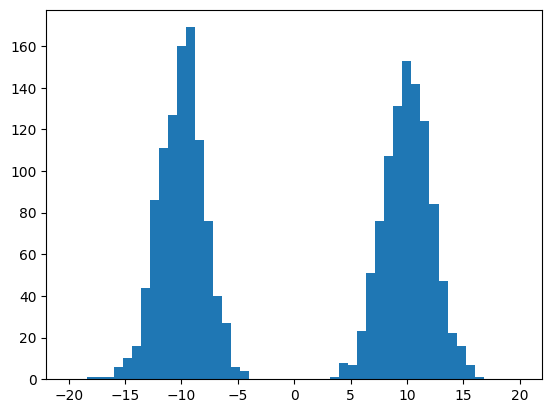

In [2]:
v=np.random.randn(100,100)
data = np.r_[np.random.normal(10, 2, 1000),np.random.normal(-10, 2, 1000)]
hist(data,50, (-20,20))
show()

En el cual definimos un ancho para los intervalos y un número de intervalos y simplemente contamos el número de puntos que cayeron en cada intervalo. En una dimensión, si la línea real es dividida en un número de celdas iguales, la estimación de densidad para un punto $x$ cualquiera será:

$$\hat{p}(x) = \frac{n_j}{\sum_{j}^{N_c}n_j dx}$$

donde $n_j$ es el número de muestras en la celda de ancho $dx$ que contiene a $x$. $N_c$ es el número de celdas. El histograma también puede ser construido en 2 o más dimensiones, tal como se muestra en la siguiente figura.

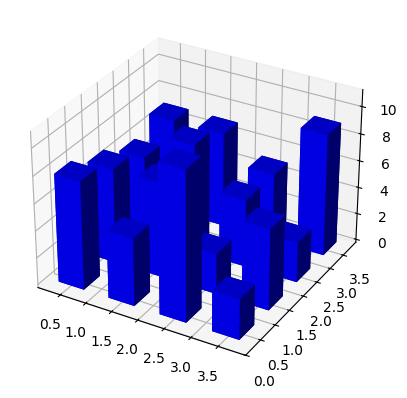

In [3]:
%matplotlib inline
#from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
fig = plt.figure()
#ax = Axes3D(fig)
ax = fig.add_subplot(projection='3d')
x, y = np.random.rand(2, 100) * 4
hist, xedges, yedges = np.histogram2d(x, y, bins=4)

elements = (len(xedges) - 1) * (len(yedges) - 1)
xpos, ypos = np.meshgrid(xedges[:-1]+0.25, yedges[:-1]+0.25)

xpos = xpos.flatten()
ypos = ypos.flatten()
zpos = np.zeros(elements)
dx = 0.5 * np.ones_like(zpos)
dy = dx.copy()
dz = hist.flatten()
ax.bar3d(xpos, ypos, zpos, dx, dy, dz, color='b')

plt.show()

En este caso, tenemos 2 variables y cada una se divide en un número finito de celdas. Si todas las celdas son de igual tamaño, la estimación de probabilidad para una muestra $\bf{x}$, será:

$$\hat{p}(x) = \frac{n_j}{N}$$

donde $N$ es el número total de muestras. ¿Cómo se puede llevar a cabo una predicción empleando el método del histograma?

Para el caso de un problema de clasificación es muy simple, y se parece mucho al problema abordado en la clase anterior. Construimos un histograma diferente para cada clase (una fdp por cada clase), usando los mismos intervalos y el mismo número de bins para todas las clases. Cuando al sistema llegue una nueva muestras, evaluamos la probabilidad de pertenecer a cada clase de acuerdo con el histograma y asignamos la muestra a la clase que proporcione mayor probabilidad.

Para el caso de regresión es un poco más complejo. El modelo de regresión se puede ver como el valor esperado de la función de probabilidad condicional $p(y|{\bf{x}})$, es decir:

$$y = f({\bf{x}}) = E[p(y|{\bf{x}})]$$

Teniendo en cuenta que $p(y,{\bf{x}}) = p(y|{\bf{x}})p({\bf{x}})$ y que:

$$E[p(y|{\bf{x}})] = \sum yp(y|{\bf{x}}) = \sum y \frac{p(y,{\bf{x}})}{p({\bf{x}})}$$

<b>Algoritmo</b>

<li>Construir un histograma con las muestras de entrenamiento que incluya tanto las variables en el vector $\bf{x}$, como la variable de salida $y$. Es decir si el vector $\bf{x}$ es de dimensión $d$, el histograma debe contener $d + 1$ variables.</li>
<li>Cuando ingrese una nueva muestra ${\bf{x}}^*$ encontrar el conjunto de celdas para las cuales la probabilidad de esa muestra es diferente de cero. Si cada variable fue dividida en $L$ diferentes celdas, entonces deben exitir $L$ celdas para las cuales $p({\bf{x}}^{ *},y) \neq 0$</li>
<li>Determinar los diferentes valores de $y_k$ que representan cada una de las $L$ celdas que cumplen la condición anterior. El valor que representa cada celda puede ser el valor medio.</li>
<li>El valor de salida del sistema corresponderá a la suma de los valores de $y_k$ multiplicados por la probabilidad de cada uno de ellos, es decir:</li>

$$y^* = \sum_{k=1}^{L} y_k \frac{p({\bf{x}}^{ *},y)}{p({\bf{x}}^{ *})}$$

Ej: Supongamos que queremos predecir el índice de precio de vivienda (House Price Index or HPI) con base en dos variables: la edad del inmueble y el valor de la hipoteca.

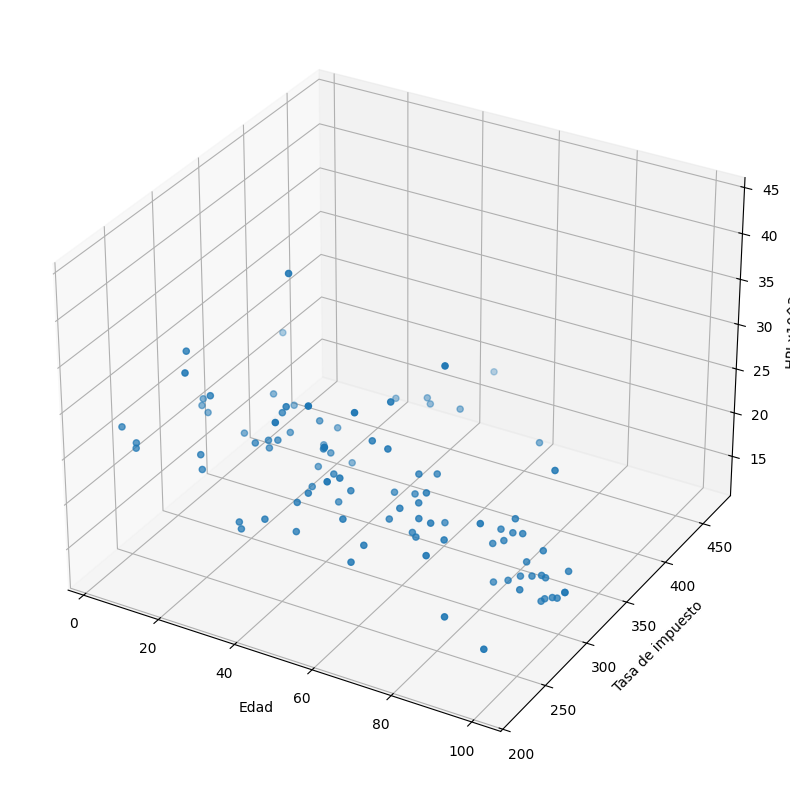

In [3]:
from local.library import plotHPI as plothpi

plothpi.plot_hpi()
plt.show()

Veamos que sucede si utilizamos algún modelo paramétrico como una regresión de órden uno u órden dos.

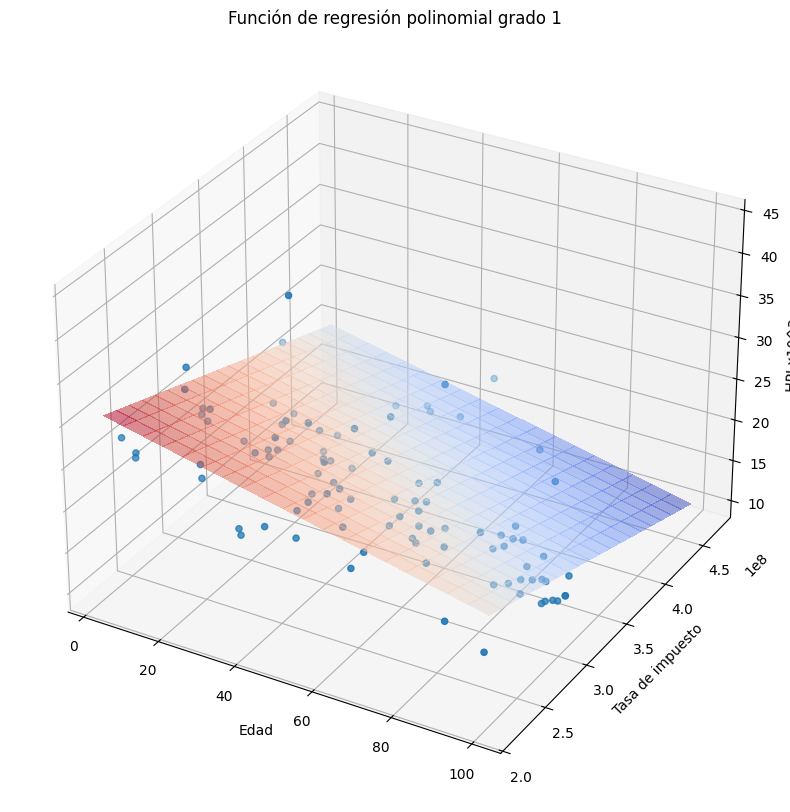

In [5]:
plothpi.Poli1()
plt.show()

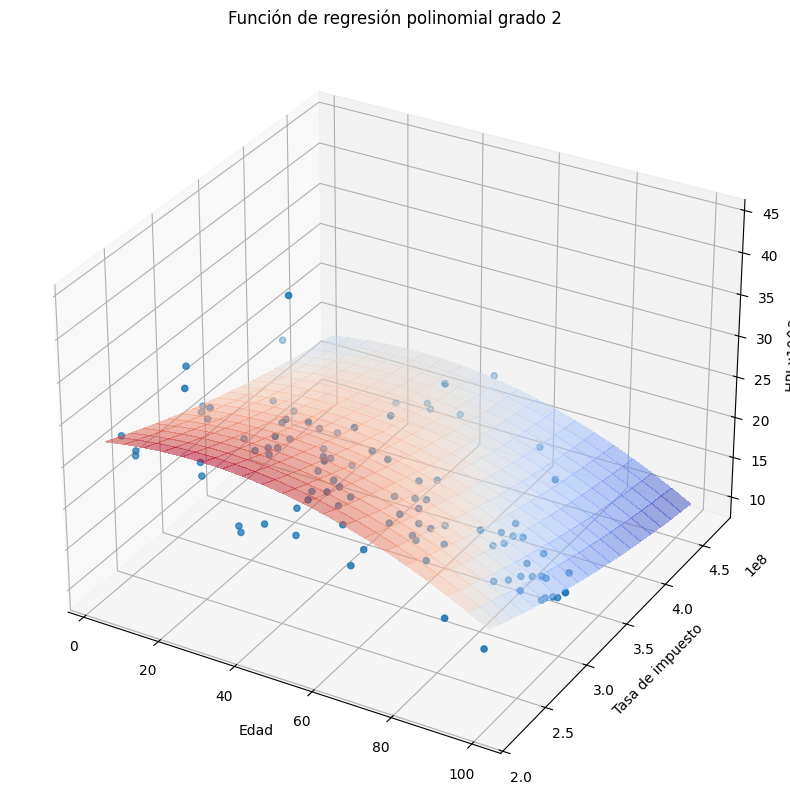

In [6]:
plothpi.Poli2()
plt.show()

Como podemos observar la aproximación a los puntos no es muy buena. Veamos que sucede si utilizamos el método del histograma, recordemos que en este caso es necesario definir el tamaño de las celdas y el punto donde comienza la primera celda.

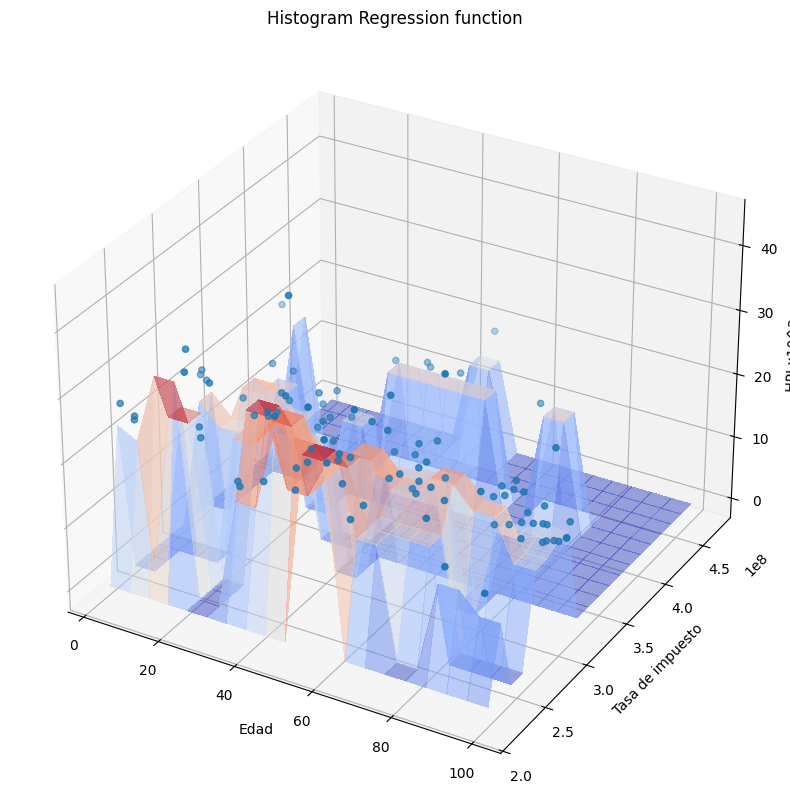

In [7]:
plothpi.HisPlot()
plt.show()

Podemos observar que la forma de la función es arbitraria, sin embargo como el conjunto de puntos con los que se cuenta para ajustar el sistemas es pequeño, la función tampoco se adapta muy bien. De manera general se puede decir que el método del histograma:


<li>Es muy simple de implementar y no requiere almacenar las muestras de entrenamiento </li>
<li>El número de celdas crece exponencialmente con la dimensión del espacio. Por consiguiente se requiere un número muy grande de muestras.</li>
<li>Presenta cambios muy fuertes y valores de probabilidad cero.</li>

----------------------------------------------------------------------------------------------------------------------------------------------

### Método de $k$-vecinos más cercanos

Los $k$ vecinos más cercanos es un algoritmo simple que almacena todos las muestras disponibles y predice un valor objetivo con base en alguna medida de similaridad. La suposición fundamental de este tipo de métodos es que los cambios de la función (modelo) que describe el comportamiento son suaves. Por consiguiente, se asume que el comportamiento de un punto puede ser estimado como el promedio del comportamiento de sus $k$-vecinos.

Por consiguiente este método requiere de la selección de 2 elementos:

<li>El número de vecinos $k$</li>
<li>La medida de distancia con base en la cual se definirá la vecindad</li>

El valor de $k$ juega un papel muy importante, un valor grande puede ayudar a eliminar ruido en los datos, pero un valor demasiado grande puede hacer perder exactitud al modelo. Por lo tanto es necesario aplicar alguna estrategia para seleccionar el mejor valor de $k$ para cada problema particular. En la próxima clase veremos cómo abordar este problema.

Por otro lado las medidas de distancia más usadas son (suponiendo que queremos medir la distancia entre un vector $\bf{x}$ y un vector $\bf{z}$, ambos de dimensión $d$):

<li>Euclidiana: $d({\bf{x}},{\bf{z}}) = \sqrt{\sum_{j=1}^{d} (x_j-z_j)^2}$</li>
<li>Manhattan: $d({\bf{x}},{\bf{z}}) =  \sum_{j=1}^d |x_j - z_j|$</li>
<li>Minkowski: $d({\bf{x}},{\bf{z}}) =  \left( \sum_{j=1}^ d (|x_j - z_j|)^q \right)^{1/q}$</li>

Para el caso de un problema de clasificación el método de $k$-vecinos se puede usar de la siguiente manera:

<li>Se selecciona un número de vecinos $k$ y una medida de distancia</li>
<li>Almacenamos el conjunto de entrenamiento, es decir las parejas $({\bf{x}}_i,y_i)_{i=1}^{N}$ </li>
<li>Cuando ingresa al sistema una nueva muestra ${\bf{x}}^*$, medimos la distancia entre la nueva muestra y todas las muestras almacenadas en el entrenamiento, es decir obtenemos los valores $v_i = d({\bf{x}}^*,{\bf{x}}_i)$</li>
<li>Encontramos los vecinos más cercanos, es decir las $k$ muestras almacenadas para las cuales dieron los menores valores $v_i$.</li>
<li>Del conjunto de muestras seleccionadas como vecinos cercanos, extraigo el valor $y_i$ asociado. Lo que tengo en este momento son las clases a las cuales pertenecen los vecinos más cercanos al punto ${\bf{x}}^*$, la clase asignada a la muestra sera la clase que más se presente en el conjunto de vecinos más cercanos, es decir la moda. Si por ejemplo 3 de los 5 vecinos más cercanos pertenecen a la clase 1 y los otros dos a la clase 2, entonces la muestra será asignada a la clase 1.</li>

Para el caso de un problema de clasificación, el procedimiento es muy similar exceptuando que la decisión final con respecto al valor de la variable de salida se toma como el promedio de los $y_i^v$ pertenecientes a los $k$-vecinos más cercanos (la $v$ es un indicador de que pertence a uno de los vecinos más cercanos).

<li>Clasificación: $y^* = \text{moda}\left(\left\lbrace y_j^{v}\right\rbrace_{j=1}^{k}\right)$</li>
<li>Regresion: $y^* = \frac{1}{k}\sum_{j=1}^{k} y_j^v$</li>

In [8]:
# Datos de Iris
iris = datasets.load_iris()
X, y = iris.data, iris.target
x_min, x_max = X[:, 1].min() - .1, X[:, 1].max() + .1
y_min, y_max = X[:, 2].min() - .1, X[:, 2].max() + .1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                         np.linspace(y_min, y_max, 100))

In [9]:
# KNN
def DiscriminatorKNN(k=3):
    neigh = KNeighborsClassifier(n_neighbors=k)
    neigh.fit(X[:,1:3], y) 
    Z = np.zeros((100,100))
    print('Calculando ... ')
    #Evaluando las fdp's en una malla de valores
    for i in range(100):
        for j in range(100):
            #print([xx[1,i],yy[j,1]])
            Z[i,j]=neigh.predict([[xx[1,i],yy[j,1]]])
    print('Listo')        
    plt.figure()
    plt.title(u'Clasificación k-vecinos, k = '+ str(k), fontsize=14)
    plt.xlabel(u'Característica 1')
    plt.ylabel(u'Característica 2')
    plt.pcolormesh(xx, yy, Z.T, cmap=CMAP_LIGHT)
    plt.scatter(X[:,1], X[:,2], c=y);
interact(DiscriminatorKNN, k=[1,2,3,4,5,10,20,100,150]);  

interactive(children=(Dropdown(description='k', index=2, options=(1, 2, 3, 4, 5, 10, 20, 100, 150), value=3), …

Si aplicamos el método de $k$-vecinos al problema de predicción de HPI, obtendremos lo siguiente:

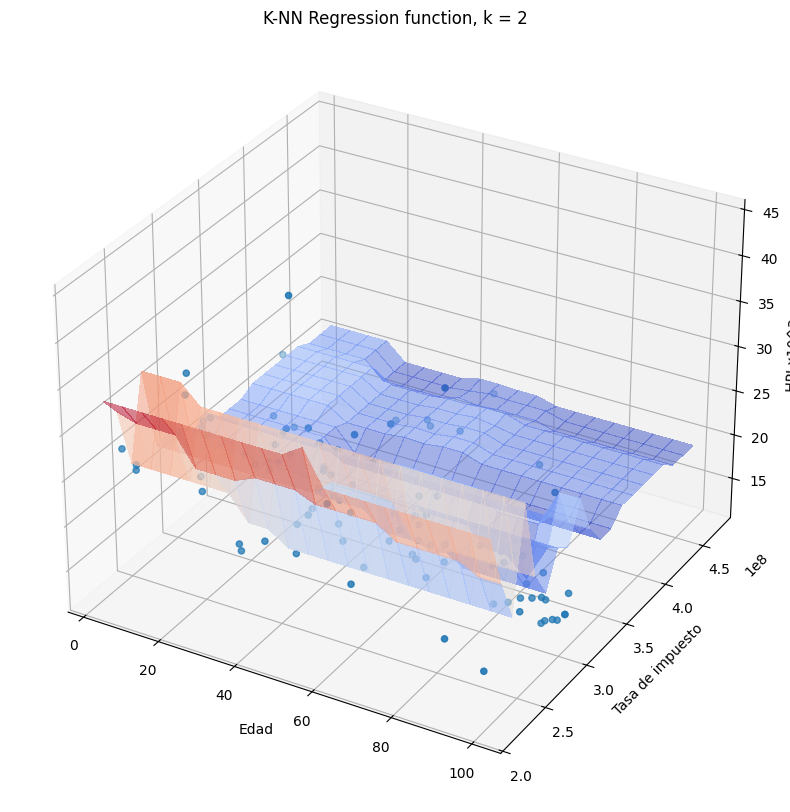

In [11]:
plothpi.knn_un(n_neighbors=2)
plt.show()

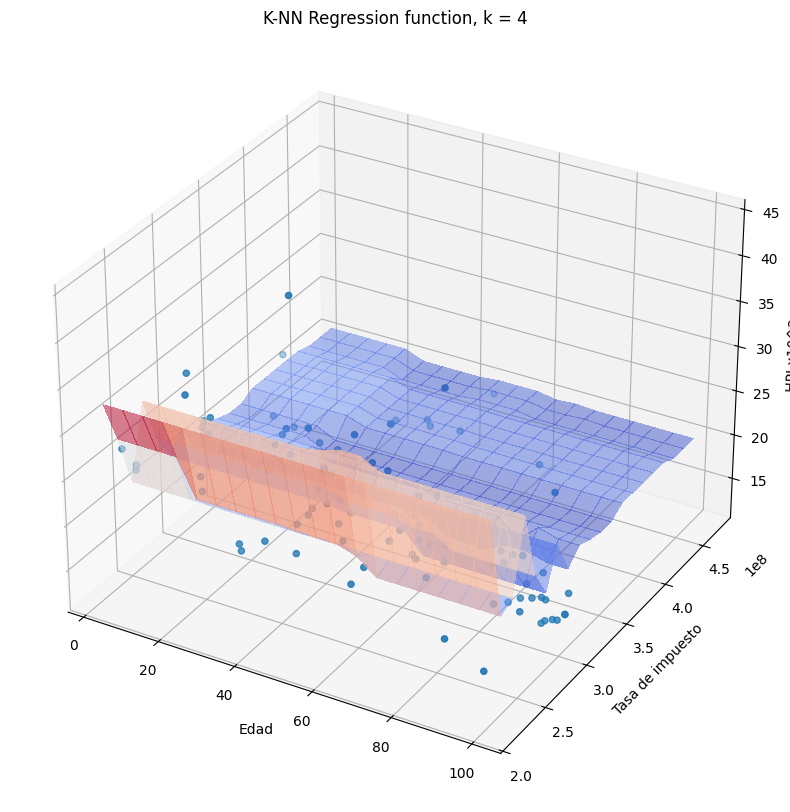

In [4]:
plothpi.knn_un(n_neighbors=4)
plt.show()

Más allá de la forma que toma la función de salida es necesario que notemos algo importante. Si observamos con detenimiento las funciones obtenidas, veremos que una de las dos variables no es tenida en cuenta en la regresión, es decir el valor es constante siempre y cuando la otra no cambie. Este fecnómeno es debido a que una de las variables toma valores en el rango de 100 mil a 300 mil, mientras que la otra toma volres en el rango de 20 a 60. Como el método de  k -vecinos está basado en una medida de distancia, es claro que la distancia de la variable Hipoteca será mucho más grande en magnitud, que la distancia de la variable edad. Por esa razón una variable opaca la otra, aunque eso no significa que la variable Hipoteca sea más importante para la predicción.

La forma en la que podemos evitar ese problema es escalando o normalizando las variables de entrada $\bf{x}$, para que todas tengan rango similares y no opaquen u oculten la información contenida en las demás. Existen varios tipos de normalización, unos de los más usados son:

 <li>max-min: ${\bf{x}}_n = \frac{{\bf{x}}-\min({\bf{X}})}{\max({\bf{X}}) - \min({\bf{X}})}$. Todas las variables quedan en el rango $[0,1]$
    <li>zscore: ${\bf{x}}_n = \frac{{\bf{x}}-mean({\bf{X}})}{std({\bf{X}})}$. Todas las variables quedan con media 0 y varianza 1.</li>

Las formulas anteriores están planteadas en términos del vector de entrada $\bf{x}$, pero es necesario comprender que las normalizaciones se aplican de manera independiente por cada una de las variables en el vector. La letra mayúscula $\bf{X}$ representa el conjunto completo de muestras de entrenamiento.

Si aplicamos la normalización max-min a las variables Hipoteca y Edad, y posteriormente realizamos la predicción usando el método de $k$-vecinos obtendremos:

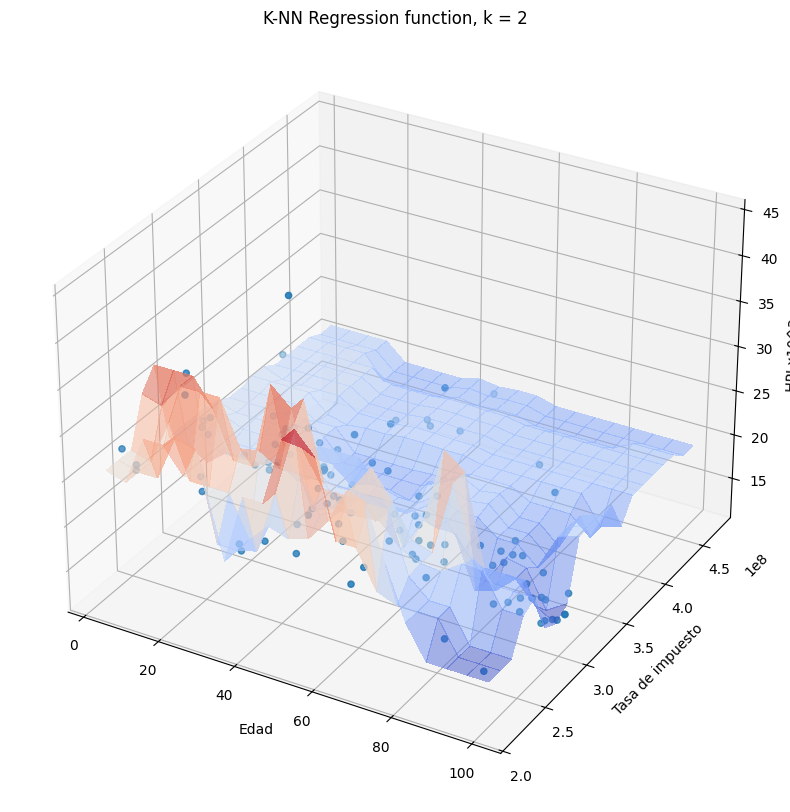

In [5]:
plothpi.knn_n(n_neighbors=2)
plt.show()

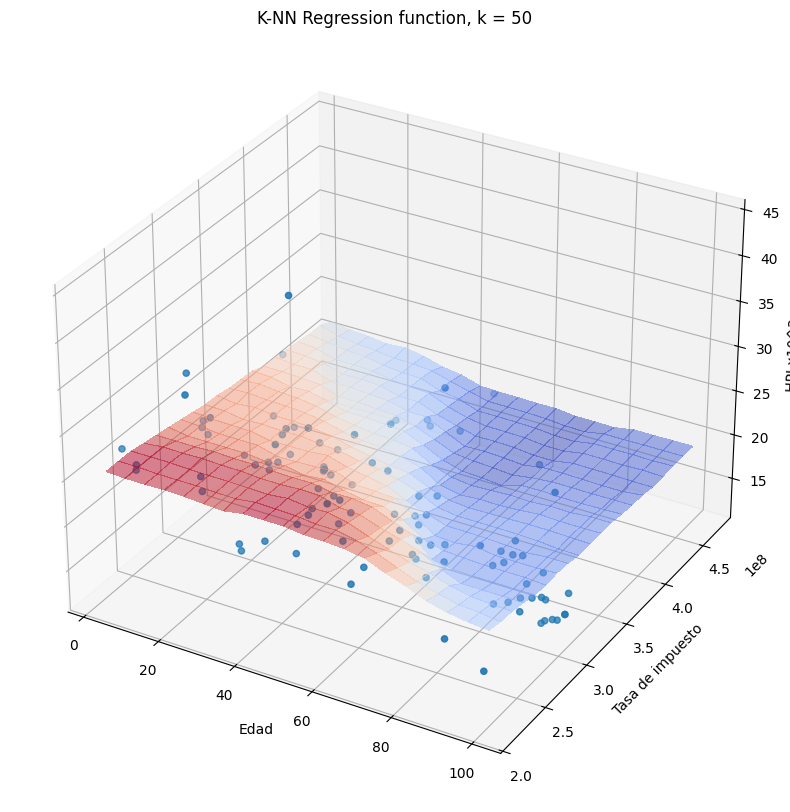

In [6]:
plothpi.knn_n(n_neighbors=50)
plt.show()

----------------------------------------------------------------------------------------------------------------------------------------------

<b>Método de ventana de Parzen</b>

La diferencia fundamental entre el método de $k$-vecinos y el método del histograma es la definición de "vecindad". En la primer caso la vecindad era un espacio definido por la celda en la cual se ubicaba un punto. Por el contrario en el método de $k$-vecinos la vecindad era un área variable definida por los punto más cercanos a la muestra en cuestión. Es decir que la vecindad podría ser grande si los puntos más cercanos están de todas maneras muy alejados o pequeña si los vecinos más cercanos están realmente cerca. El método de ventana de Parzen es en esencia un método similar a los dos anteriores, pero no define una vecindad, sino que por el contrario toma en cuenta todos los puntos del conjunto de entrenamiento para realizar la predicción. El método de ventana de Parzen le da un peso a cada una de las muestras de entrenamiento con base en la distancia a la muestra objetivo, si la distancia es corta esa muestra de entrenamiento tendrá mucho peso en el valor asignado a la variable a predecir y si la distancia es muy grande el peso de dicha muestra será mucho menor.  

La función de densidad de probabilidad utilizando el método de ventana de Parzen está dado por:

$$f({\bf{x}}^*) = \frac{1}{N h^d} \sum_{i=1}^{N} K(u_i), \;\; u_i = \frac{dist({\bf{x}}^*,{\bf{x}}_i)}{h}\;\;\;\;\;\; (1)$$

donde $K$ se conoce como función kernel y es la función encargada de dar un peso a cada una de las muestras de entrenamiento $i$, con base en la distancia a la muestra nueva ${\bf{x}}^*$. $h$ es un parámetro de la ventana que regula su ancho, es decir si le da mayor o menor peso a los puntos alejados. Si usamos $K$ igual a una ventana cuadrada, tendríamos un resultado parecido al del método del histograma.

Existen muchas funciones kernel que se pueden usar, la más empleada es la función de kernel Gausiano dada por:

$$K(u)=\exp(-\frac{1}{2}u^2)$$

En este caso la función es similar a una ventana Gaussiana con media cero, es decir que le dará mayor peso a los puntos cuya distancia sea cercana a cero y menor peso a los puntos distantes. El valor de h en este caso se puede asemejar a la desviación de la función Gausiana, es decir que controla su ancho.

In [11]:
# Distribucion

def DistributionPW(h=0.5):
    mu1, sigma1 = 0, 0.3
    mu2, sigma2 = 3, 0.5
    np.random.seed(1)
    Normal1 = np.random.normal(mu1, sigma1, 200)
    Normal2 = np.random.normal(mu2, sigma2, 200)
    
    X = np.append(Normal1,Normal2)
    fig, ((ax1, ax2)) = plt.subplots(1, 2) 

    x = sorted(np.random.randn(200) +2 )
    pred = list()
    for i in range(len(x)):
        pred.append(plothpi.parzenW(X,x[i],h))
    ax2.plot(x,pred,'-o')
    ax1.hist(Normal1,density=True,color='steelblue')
    ax1.hist(Normal2,density=True,color='steelblue')
    fig.show()
interact(DistributionPW, h=[0.01,0.05,0.1,0.5,1,2,3,4,5,6]); 

interactive(children=(Dropdown(description='h', index=3, options=(0.01, 0.05, 0.1, 0.5, 1, 2, 3, 4, 5, 6), val…

Como el valor entregado por la función de ventana de Parzen corresponde a una estimación de la función de densidad de probabilidad, para problemas de clasificación debemos dividir las muestras de entrenamiento en cada una de las clases y estimar la probabilidad de una muestra nueva en cada una de ellas usando la ecuación (1). Es decir, es el mismo procedimiento descrito en la clase anterior pero cambiando la función que estima la fdp.

In [12]:
# Ventana de Parzen

def DiscriminatorParzen(h=0.01):
    print("Calculando...")
    Z = np.zeros((100,100))
    #Evaluando las fdp's en una malla de valores
    plt.clf()
    for i in range(100):
        for j in range(100):
            p1 = plothpi.parzenW(X[:50,1:3],[xx[1,i],yy[j,1]],h)
            p2 = plothpi.parzenW(X[50:100,1:3],[xx[1,i],yy[j,1]],h)
            p3 = plothpi.parzenW(X[100:150,1:3],[xx[1,i],yy[j,1]],h)
            p = np.array([p1,p2,p3]);
            Z[i,j]= p.argmax(axis=0)
    print('Listo.')        
    ax = plt.subplot()
    plt.title(u'Clasificación Ventana de Parzen h = ' + str(h), fontsize=14)
    plt.xlabel(u'Característica 1')
    plt.ylabel(u'Característica 2')
    ax.pcolormesh(xx, yy, Z.T, cmap=CMAP_LIGHT)
    ax.scatter(X[:,1], X[:,2], c=y);
interact(DiscriminatorParzen, h=[0.001,0.01,0.1,1,2,3,4,5,6]);

interactive(children=(Dropdown(description='h', index=1, options=(0.001, 0.01, 0.1, 1, 2, 3, 4, 5, 6), value=0…

Para el caso de **regresión**, es necesario estimar el valor esperado de la distribución condicional. La formulación del modelo puede hacerse de maneras difirentes, el modelo más usado es:

<li>Estimador de Nadaraya-Watson: $$y^* = \frac{\sum_{i=1}^N K(u_i)y_i}{\sum_{i=1}^N K(u_i)}, \;\; u_i = \frac{dist({\bf{x}}^*,{\bf{x}}_i)}{h}$$
</li>

Si usamos el estimador de Nadaraya-Watson en el problema de predicción de HPI (**sin** normalización de variables) obtendremos:

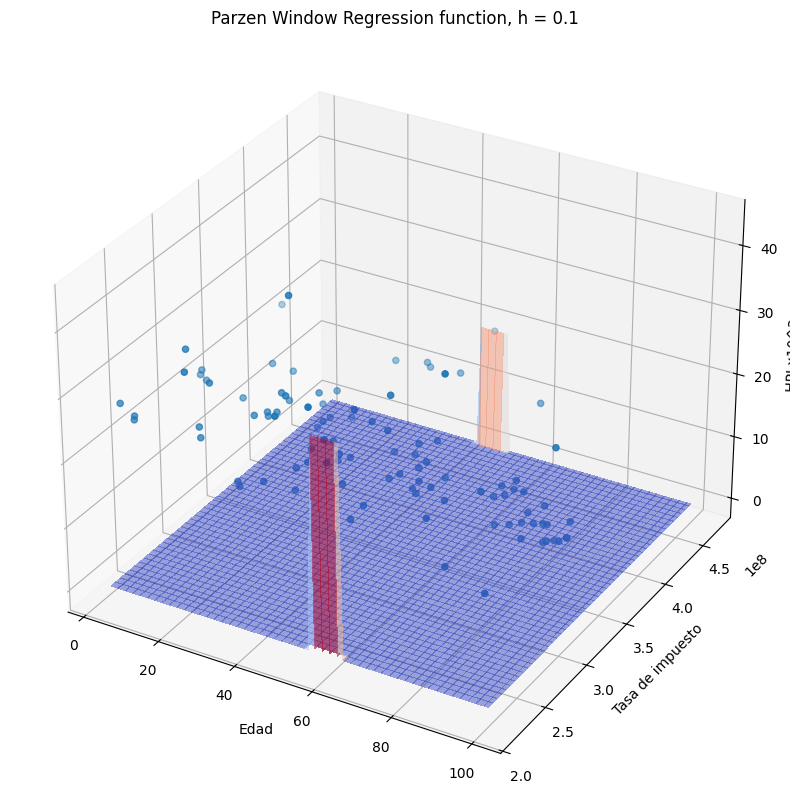

In [28]:
plothpi.ParzenPlot_un(0.1)
plt.show()

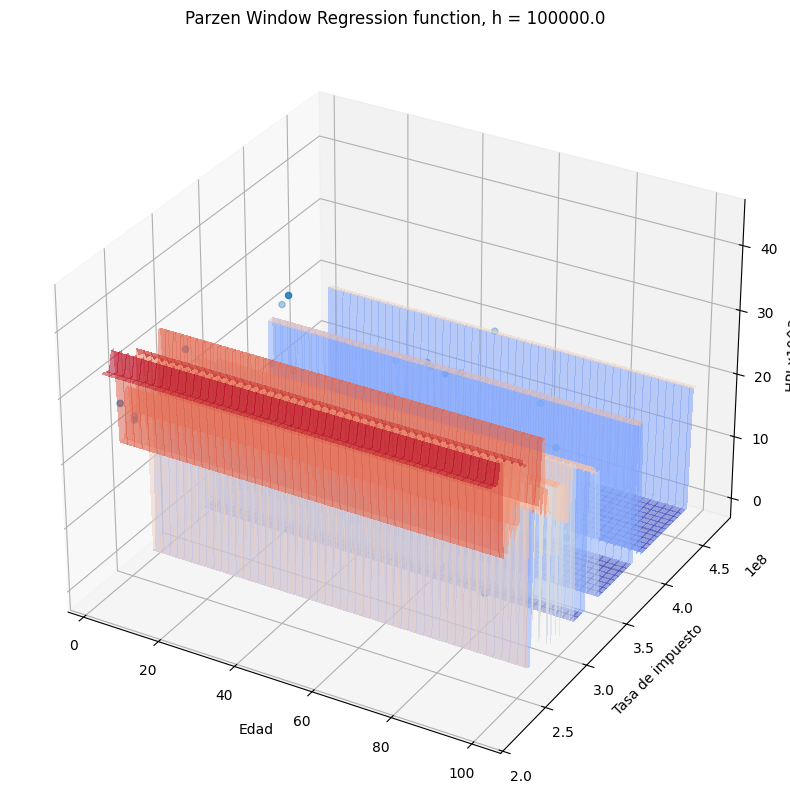

In [29]:
plothpi.ParzenPlot_un(1e5)
plt.show()

Si usamos el estimador de Nadaraya-Watson en el problema de predicción de HPI (**previa** normalización de variables) obtendremos:

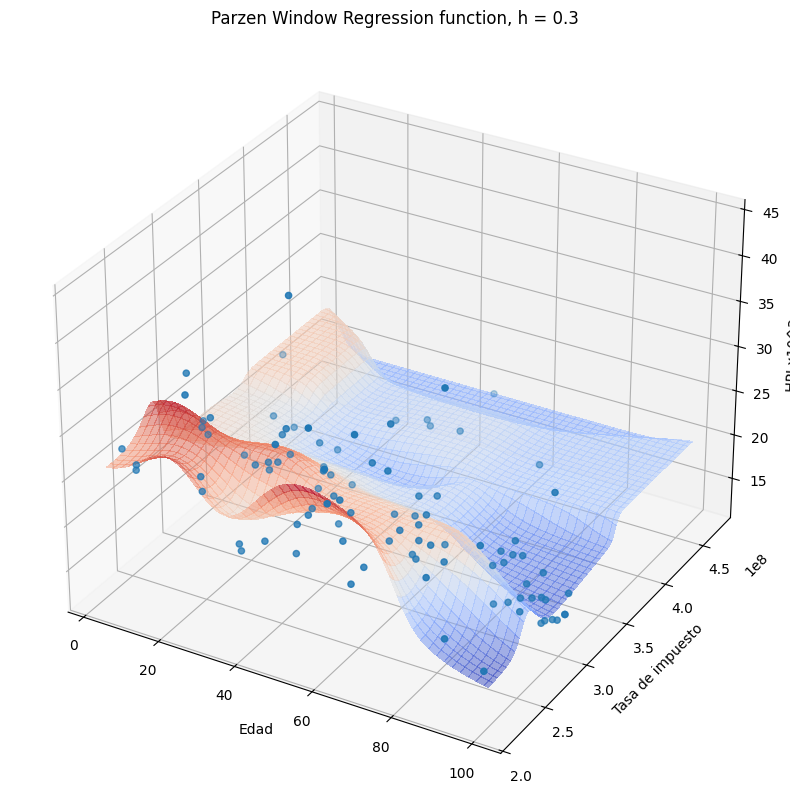

In [14]:
plothpi.ParzenPlot_n(0.3)
plt.show()

Note que a diferencia de los métodos anteriores, en este caso se obtiene una función suave debido a que la medida de similitud (la función kernel), es una función suave.

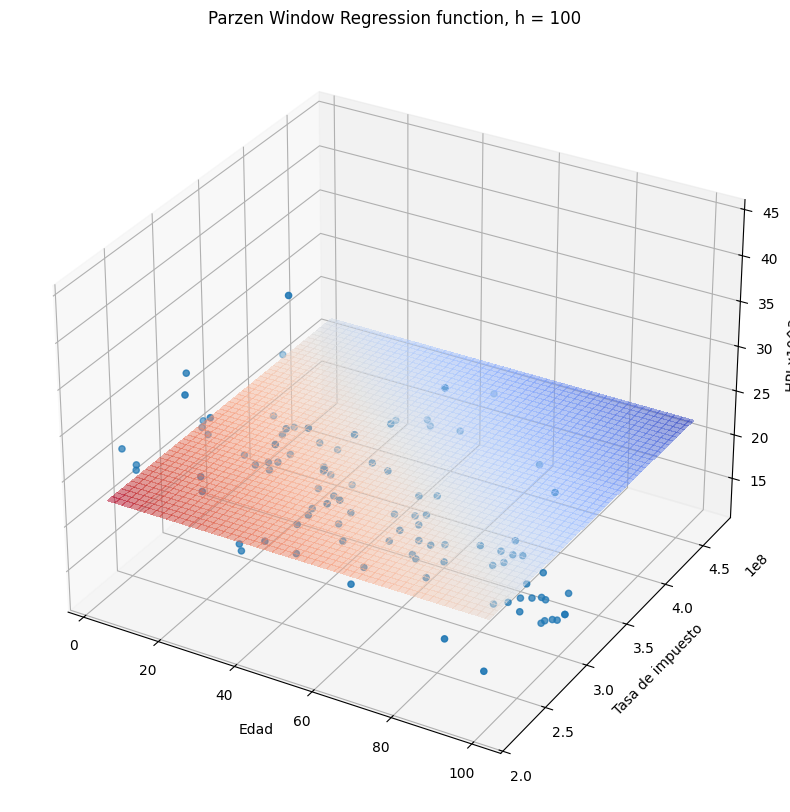

In [31]:
plothpi.ParzenPlot_n(100)
plt.show()

Sin embargo, si el valor de h se hace más pequeño, la función se hace más aguda en cada uno de los puntos del conjunto de entrenamiento, debido a que la similitud es más estricta, sólo muestras de entrenamiento muy cercanos a la muestra sobre la cual se quiere hacer la predicción, aportarán a la misma. Escoger el valor correcto para $h$ puede no ser una tarea facil. Un estimador muy usado es el conocido como “Silverman bandwidth” (<mark>consultar</mark>)

In [15]:
# Regression
X_nadayara = np.sort(4 * np.random.rand(100, 1), axis=0)
y_nadayara = np.sin(X_nadayara).ravel()
y_nadayara += 0.5 * (0.5 - np.random.rand(y_nadayara.size))

def nadayara(h=0.48859075319621886):
    #ndwM = ndw(h)
    pred = list()
    for i in range(len(X_nadayara)):
        pred.append(plothpi.nadaraya_watson(X_nadayara, X_nadayara[i], y_nadayara,h))
    plt.scatter(X_nadayara, y_nadayara,c='k', label='Datos Originales')
    plt.plot(X_nadayara, pred,'--' , c='r', label='NadarayaWatson')
    plt.legend()
    plt.show()
interact(nadayara, h=[0.0001,0.001,0.01,0.1,0.48859075319621886,0.5,0.6,0.7,0.8]);   

interactive(children=(Dropdown(description='h', index=4, options=(0.0001, 0.001, 0.01, 0.1, 0.4885907531962188…

----------------------------------------------------------------------------------------------------------------------------------------------

Los modelos no paramétricos son muy flexibles porque permiten construir fronteras de decisión o funciones de regresión muy variadas, pero son computacionalmente muy ineficientes para conjuntos de datos muy grandes debido a que como hemos visto, para la mayoría, es necesario almacenar todas las muestras de entrenamiento y realizar cáculos de distancia con respecto a todas las muetras de entrenamiento cada vez que necesitemos realizar una nueva predicción. Por esta razón se han propuesto muchas variantes para trabajar con conjuntos de datos masivos.